# Section 5 Analysis: Local Ollama vs Cloud OpenAI

This notebook analyzes the results from section 5 experiments, which compare local Ollama models with cloud-based OpenAI models.

## Experiments Being Compared

1. **5.1 - Baseline (Local)**: Ollama LLM (llama3.2) + Ollama embeddings (nomic-embed-text)
2. **5.2 - Hybrid**: OpenAI LLM (gpt-4o-mini) + Ollama embeddings (nomic-embed-text)
3. **5.3 - Full Cloud**: OpenAI LLM (gpt-4o-mini) + OpenAI embeddings (text-embedding-3-small)

**Note:** Using `gpt-4o-mini` for fair comparison with llama3.2 8B model size.

## Research Questions

- How does cloud-based LLM compare to local Ollama in terms of latency and quality?
- What is the impact of using cloud embeddings vs local embeddings?
- What are the tradeoffs: cost, privacy, offline capability, setup complexity?



In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

# Set matplotlib style
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

# Load all three experiment results
# Note: Filenames include provider tags (ollama-ollama, openai-ollama, openai-openai)
baseline_file = "results/chunk1200_overlap300_k3_ollama-ollama_llama3.2_nomic-embed-text.csv"
hybrid_file = "results/chunk1200_overlap300_k3_openai-ollama_gpt-4o-mini_nomic-embed-text.csv"
cloud_file = "results/chunk1200_overlap300_k3_openai-openai_gpt-4o-mini_text-embedding-3-small.csv"

# Try to load files (some may not exist if experiments failed)
dfs = {}
for name, file in [("Baseline", baseline_file), ("Hybrid", hybrid_file), ("Cloud", cloud_file)]:
    if os.path.exists(file):
        dfs[name] = pd.read_csv(file)
        print(f"✓ Loaded {name}: {file} ({len(dfs[name])} questions)")
    else:
        print(f"✗ Not found: {file}")

if not dfs:
    print("\nNo experiment results found. Please run experiments/5_runner.py first.")
else:
    print("\n" + "="*80)



✓ Loaded Baseline: results/chunk1200_overlap300_k3_ollama-ollama_llama3.2_nomic-embed-text.csv (4 questions)
✗ Not found: results/chunk1200_overlap300_k3_openai-ollama_gpt-4o-mini_nomic-embed-text.csv
✗ Not found: results/chunk1200_overlap300_k3_openai-openai_gpt-4o-mini_text-embedding-3-small.csv



## Configuration Comparison

Comparing the key configuration parameters across experiments:


In [2]:
if dfs:
    # Create comparison table
    config_data = {}
    for name, df in dfs.items():
        config_data[name] = [
            df["LLM Model"].iloc[0],
            df["Embedding Model"].iloc[0],
            df["Chunk Size"].iloc[0],
            df["Chunk Overlap"].iloc[0],
            df["Retrieval K"].iloc[0],
            df["Number of Chunks"].iloc[0],
        ]
    
    config_comparison = pd.DataFrame(
        config_data,
        index=["LLM Model", "Embedding Model", "Chunk Size", "Chunk Overlap", "Retrieval K", "Number of Chunks"]
    )
    
    display(config_comparison)
    
    print("\nKey Differences:")
    if "Baseline" in dfs:
        print("  - Baseline: Local Ollama for both LLM and embeddings")
    if "Hybrid" in dfs:
        print("  - Hybrid: OpenAI LLM + Local Ollama embeddings")
    if "Cloud" in dfs:
        print("  - Full Cloud: OpenAI for both LLM and embeddings")



,Baseline
LLM Model,llama3.2
Embedding Model,nomic-embed-text
Chunk Size,1200
Chunk Overlap,300
Retrieval K,3
Number of Chunks,175



Key Differences:
  - Baseline: Local Ollama for both LLM and embeddings


## Runtime Metrics Comparison

Comparing indexing times and response times across experiments:


,Baseline
Indexing Time (s),29.74
Average Response Time (s),12.52



Performance Comparison (vs Baseline):


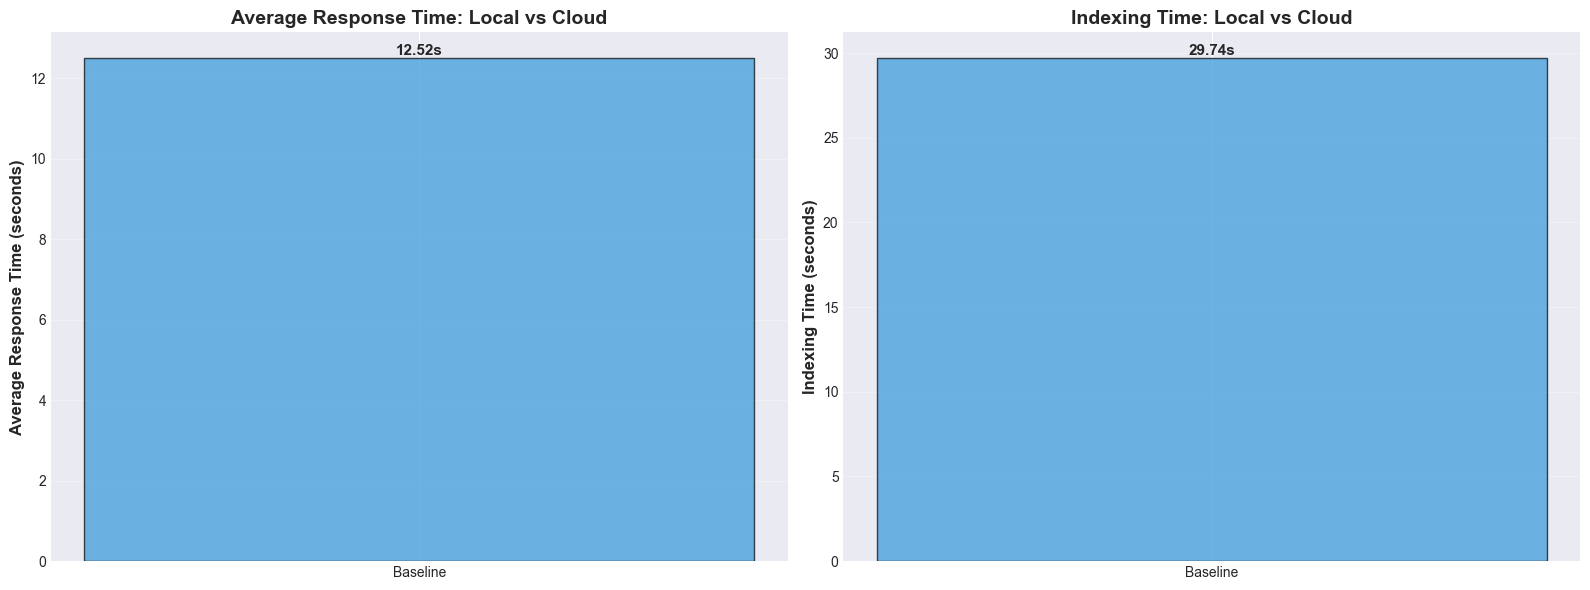

In [3]:
if dfs:
    # Runtime metrics comparison
    runtime_data = {}
    for name, df in dfs.items():
        runtime_data[name] = [
            df["Indexing Time (s)"].iloc[0],
            df["Average Response Time (s)"].iloc[0],
        ]
    
    runtime_metrics = pd.DataFrame(
        runtime_data,
        index=["Indexing Time (s)", "Average Response Time (s)"]
    )
    
    display(runtime_metrics)
    
    if "Baseline" in dfs:
        baseline_time = dfs["Baseline"]["Average Response Time (s)"].iloc[0]
        print("\nPerformance Comparison (vs Baseline):")
        for name, df in dfs.items():
            if name != "Baseline":
                time = df["Average Response Time (s)"].iloc[0]
                change = ((time / baseline_time) - 1) * 100
                print(f"  {name}: {time:.2f}s ({change:+.1f}%)")
    
    # Visualization: Performance Metrics Comparison
    if len(dfs) > 0:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        experiment_names = list(dfs.keys())
        avg_response_times = [df["Average Response Time (s)"].iloc[0] for df in dfs.values()]
        indexing_times = [df["Indexing Time (s)"].iloc[0] for df in dfs.values()]
        colors = ['#3498db', '#2ecc71', '#e74c3c'][:len(experiment_names)]
        
        # Average Response Time
        bars1 = ax1.bar(experiment_names, avg_response_times, color=colors, alpha=0.7, edgecolor='black')
        ax1.set_ylabel('Average Response Time (seconds)', fontsize=12, fontweight='bold')
        ax1.set_title('Average Response Time: Local vs Cloud', fontsize=14, fontweight='bold')
        ax1.grid(axis='y', alpha=0.3)
        for bar, time in zip(bars1, avg_response_times):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{time:.2f}s', ha='center', va='bottom', fontsize=11, fontweight='bold')
        
        # Indexing Time
        bars2 = ax2.bar(experiment_names, indexing_times, color=colors, alpha=0.7, edgecolor='black')
        ax2.set_ylabel('Indexing Time (seconds)', fontsize=12, fontweight='bold')
        ax2.set_title('Indexing Time: Local vs Cloud', fontsize=14, fontweight='bold')
        ax2.grid(axis='y', alpha=0.3)
        for bar, time in zip(bars2, indexing_times):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                    f'{time:.2f}s', ha='center', va='bottom', fontsize=11, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        # Visualization: Response Times per Question
        if len(dfs) > 1:
            fig, ax = plt.subplots(figsize=(14, 7))
            x = np.arange(len(list(dfs.values())[0]))
            width = 0.8 / len(dfs)
            
            questions_short = [f"Q{i+1}" for i in range(len(list(dfs.values())[0]))]
            
            for i, (name, df) in enumerate(dfs.items()):
                offset = (i - len(dfs)/2 + 0.5) * width
                response_times = df["Response Time (s)"].values
                ax.bar(x + offset, response_times, width, label=name, 
                      color=colors[i], alpha=0.7, edgecolor='black')
            
            ax.set_xlabel('Question', fontsize=12, fontweight='bold')
            ax.set_ylabel('Response Time (seconds)', fontsize=12, fontweight='bold')
            ax.set_title('Response Time per Question: Local vs Cloud Comparison', fontsize=14, fontweight='bold')
            ax.set_xticks(x)
            ax.set_xticklabels(questions_short)
            ax.legend(fontsize=11)
            ax.grid(axis='y', alpha=0.3)
            
            plt.tight_layout()
            plt.show()



## Response Quality Evaluation

Comparing response quality across experiments for each question:


### Question 1: What is Apache Iceberg? Explain in short.


In [4]:
if dfs:
    q1_data = {}
    for name, df in dfs.items():
        q1_data[name] = df.iloc[0]
    
    print("**Question:**", q1_data[list(q1_data.keys())[0]]["Question"])
    print("\n" + "="*80)
    
    for name, q1 in q1_data.items():
        print(f"**{name} Response:**")
        print(q1["Response"])
        print(f"Response Time: {q1['Response Time (s)']}s")
        print("\n" + "="*80)



**Question:** What is Apache Iceberg? Explain in short.

**Baseline Response:**
Apache Iceberg is a scalable, distributed file system designed for managing large, slow-changing collections of files in a key-value store or distributed file system. It provides a flexible and efficient way to store and manage data, with features such as versioning, encryption, and schema evolution.
Response Time: 10.91s



**Quality Assessment:**

Compare the responses across experiments:
- Are cloud responses more detailed or concise?
- Do they maintain similar accuracy?
- Note any differences in response style or completeness



## Summary & Findings

### Key Metrics Summary


,Metric,Baseline
0,LLM Provider,llama3.2
1,Embedding Provider,nomic-embed-text
2,Number of Chunks,175
3,Indexing Time (s),29.74
4,Avg Response Time (s),12.52


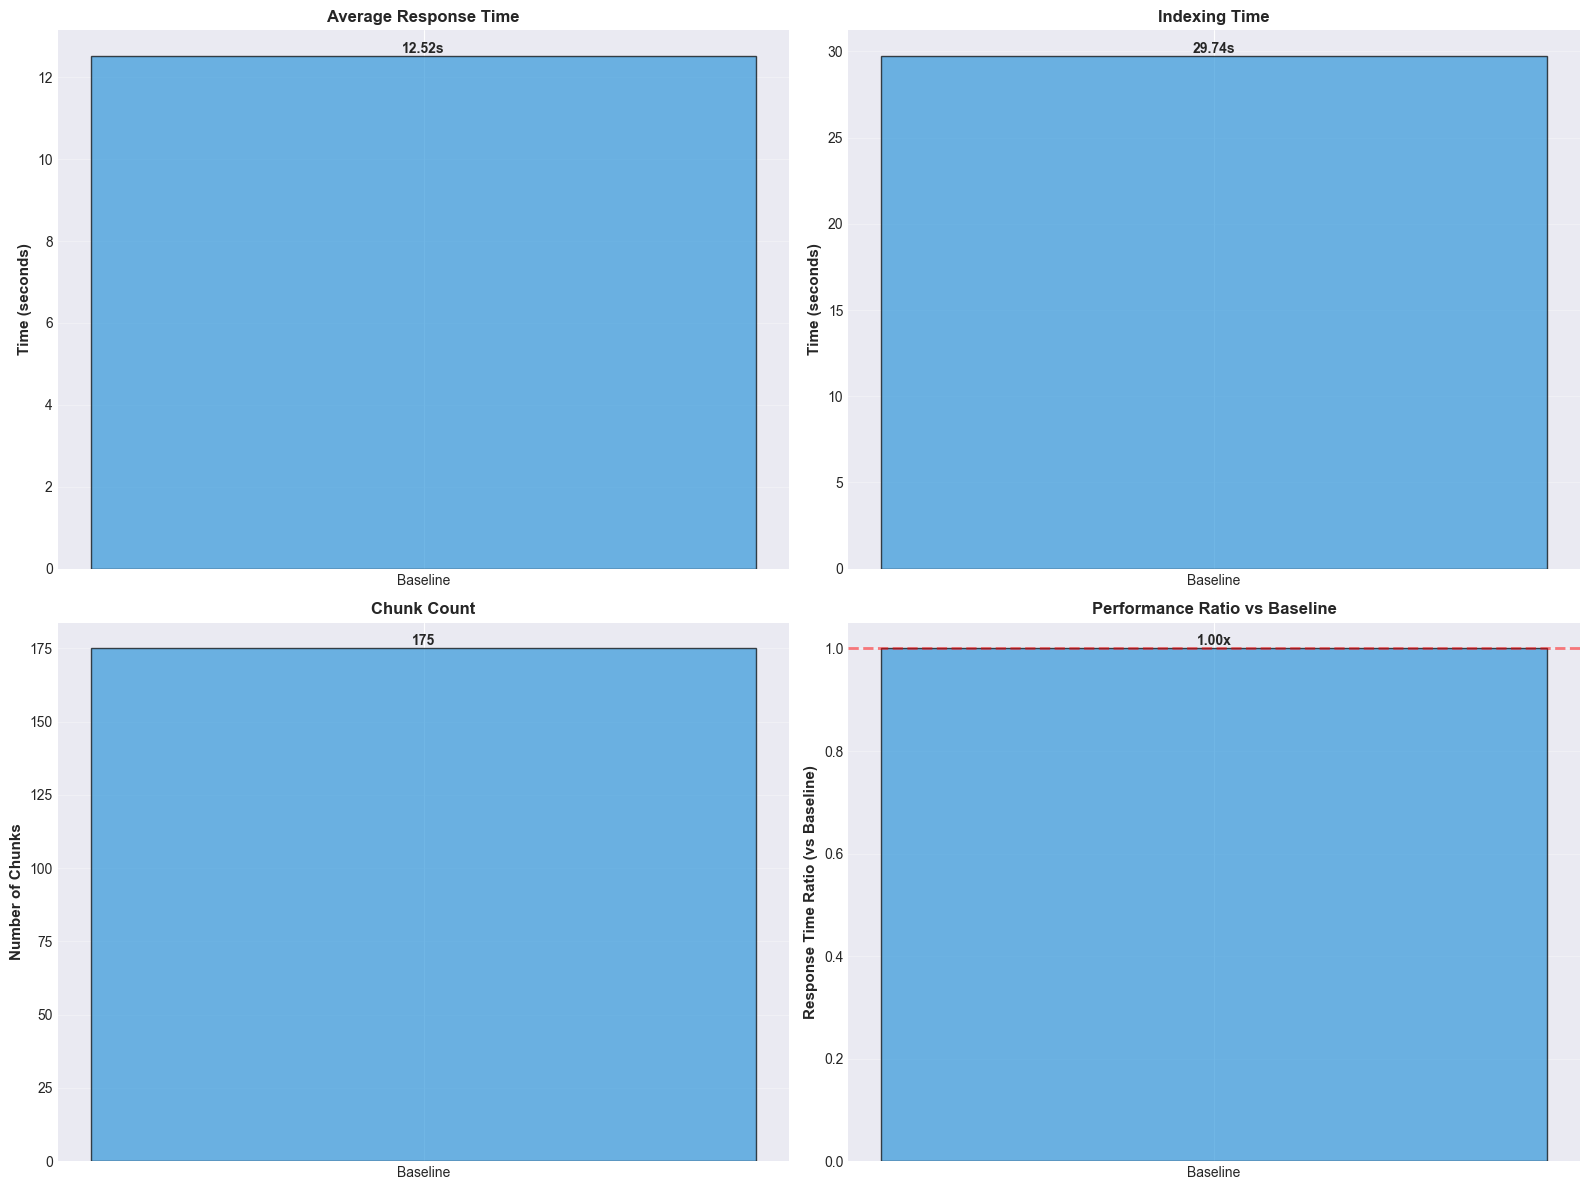

In [5]:
if dfs:
    summary_data = {
        "Metric": [
            "LLM Provider",
            "Embedding Provider",
            "Number of Chunks",
            "Indexing Time (s)",
            "Avg Response Time (s)",
        ]
    }
    
    for name, df in dfs.items():
        summary_data[name] = [
            df["LLM Model"].iloc[0],
            df["Embedding Model"].iloc[0],
            df["Number of Chunks"].iloc[0],
            f"{df['Indexing Time (s)'].iloc[0]:.2f}",
            f"{df['Average Response Time (s)'].iloc[0]:.2f}",
        ]
    
    summary_df = pd.DataFrame(summary_data)
    display(summary_df)
    
    # Visualization: Comprehensive Comparison
    if len(dfs) > 0:
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        experiment_names = list(dfs.keys())
        colors = ['#3498db', '#2ecc71', '#e74c3c'][:len(experiment_names)]
        
        # 1. Average Response Time
        avg_response_times = [df["Average Response Time (s)"].iloc[0] for df in dfs.values()]
        bars1 = axes[0, 0].bar(experiment_names, avg_response_times, color=colors, alpha=0.7, edgecolor='black')
        axes[0, 0].set_ylabel('Time (seconds)', fontsize=11, fontweight='bold')
        axes[0, 0].set_title('Average Response Time', fontsize=12, fontweight='bold')
        axes[0, 0].grid(axis='y', alpha=0.3)
        for bar, time in zip(bars1, avg_response_times):
            height = bar.get_height()
            axes[0, 0].text(bar.get_x() + bar.get_width()/2., height,
                           f'{time:.2f}s', ha='center', va='bottom', fontsize=10, fontweight='bold')
        
        # 2. Indexing Time
        indexing_times = [df["Indexing Time (s)"].iloc[0] for df in dfs.values()]
        bars2 = axes[0, 1].bar(experiment_names, indexing_times, color=colors, alpha=0.7, edgecolor='black')
        axes[0, 1].set_ylabel('Time (seconds)', fontsize=11, fontweight='bold')
        axes[0, 1].set_title('Indexing Time', fontsize=12, fontweight='bold')
        axes[0, 1].grid(axis='y', alpha=0.3)
        for bar, time in zip(bars2, indexing_times):
            height = bar.get_height()
            axes[0, 1].text(bar.get_x() + bar.get_width()/2., height,
                           f'{time:.2f}s', ha='center', va='bottom', fontsize=10, fontweight='bold')
        
        # 3. Number of Chunks
        chunk_counts = [df["Number of Chunks"].iloc[0] for df in dfs.values()]
        bars3 = axes[1, 0].bar(experiment_names, chunk_counts, color=colors, alpha=0.7, edgecolor='black')
        axes[1, 0].set_ylabel('Number of Chunks', fontsize=11, fontweight='bold')
        axes[1, 0].set_title('Chunk Count', fontsize=12, fontweight='bold')
        axes[1, 0].grid(axis='y', alpha=0.3)
        for bar, count in zip(bars3, chunk_counts):
            height = bar.get_height()
            axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                           f'{int(count)}', ha='center', va='bottom', fontsize=10, fontweight='bold')
        
        # 4. Performance Ratio (if baseline exists)
        if "Baseline" in dfs:
            baseline_time = dfs["Baseline"]["Average Response Time (s)"].iloc[0]
            performance_ratios = [df["Average Response Time (s)"].iloc[0] / baseline_time for df in dfs.values()]
            bars4 = axes[1, 1].bar(experiment_names, performance_ratios, color=colors, alpha=0.7, edgecolor='black')
            axes[1, 1].axhline(y=1.0, color='red', linestyle='--', linewidth=2, alpha=0.5)
            axes[1, 1].set_ylabel('Response Time Ratio (vs Baseline)', fontsize=11, fontweight='bold')
            axes[1, 1].set_title('Performance Ratio vs Baseline', fontsize=12, fontweight='bold')
            axes[1, 1].grid(axis='y', alpha=0.3)
            for bar, ratio in zip(bars4, performance_ratios):
                height = bar.get_height()
                axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                               f'{ratio:.2f}x', ha='center', va='bottom', fontsize=10, fontweight='bold')
        else:
            axes[1, 1].axis('off')
        
        plt.tight_layout()
        plt.show()



### Findings

#### Local vs Cloud Comparison

**Latency Impact:**
- Compare response times between local and cloud
- Note network latency for cloud requests
- Embedding generation time differences

**Quality Impact:**
- Compare response accuracy and completeness
- Note any differences in response style
- Check if cloud models provide better/worse answers

**Tradeoffs:**
- **Cost**: Cloud requires API usage (trackable via OpenAI dashboard)
- **Privacy**: Local keeps data on-premise, cloud sends data to OpenAI
- **Offline Capability**: Local works offline, cloud requires internet
- **Setup Complexity**: Local requires Ollama installation, cloud just needs API key
- **Reliability**: Cloud may have rate limits, network issues; local depends on hardware

### Recommendations

1. **For production with privacy concerns**: Use local Ollama
2. **For faster development/testing**: Use cloud OpenAI (simpler setup)
3. **For cost-sensitive applications**: Use local (no API costs)
4. **For offline applications**: Use local (no network dependency)

### What Breaks?

- **Cloud LLM**: Requires internet connection, API key, may have rate limits
- **Cloud Embeddings**: Additional API costs, network dependency for indexing
- **Hybrid Approach**: Good balance - cloud LLM quality with local embedding privacy

